In [1]:
import matplotlib.pyplot as plt
import kwant
import numpy as np
import scipy
import scipy.ndimage
import scipy.linalg as la
from types import SimpleNamespace
%matplotlib inline

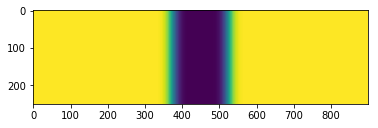

In [15]:
designfile = '/home/nefta/thesis/designfiles/waveguide3_2_small.png'
topgate = 1 - scipy.ndimage.imread(designfile, mode='L')/ 255
decay = 15
topgate_gauss = scipy.ndimage.gaussian_filter(topgate, decay)
plt.imshow(topgate_gauss)
#scattering_region = np.fliplr(1 - scipy.ndimage.imread(
#    '/home/nefta/thesis/designfiles/scatteringRegion.png', mode='L').T / 255)
scattering_region = np.ones(topgate.shape)

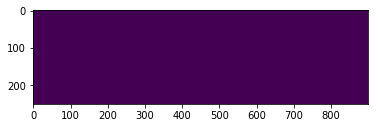

In [16]:
plt.imshow(scattering_region)

In [25]:
topgate.shape[0]*a

100.4

In [24]:
delta = 1.0 
T = delta / 2
eta = 2.5 
gamma = 0.4
at = 5
a = 0.4

#depth = 20
#size = 0.5

### zigzag edge

from math import sqrt

sin30, cos20 = sin30, cos30 = (1/2, sqrt(3)/2)
bilayer = kwant.lattice.general([(at*1, 0), (at*sin30, at*cos30)],
                                 [(0, 0), (0, at/sqrt(3)), 
                                  (0, 0), (at/2, at/(2*sqrt(3)))])

a1, b1, a2, b2 = bilayer.sublattices

hoppings1 = (((0, 0), a1, b1), ((-1, 1), a1, b1), ((0, 1), a1, b1))
hoppings2 = (((0,0), a2, b2), ((1,0), a2, b2), ((0, 1), a2, b2))

potential = scipy.interpolate.RectBivariateSpline(
    x=(a*np.arange(topgate_gauss.shape[0])),
    y=(a*np.arange(topgate_gauss.shape[1])),
    z=topgate_gauss,
    kx=1,
    ky=1,
)

### armchair edge

In [6]:
bilayer =  kwant.lattice.general([(at*np.sqrt(3)/2, at*1/2), (0, at*1)],
                                 [(0, 0.0), (at*1 / (2*np.sqrt(3)), at*1/2), 
                                  (-at*1/(2*np.sqrt(3)), at*1/2), (0, 0)])

a1, b1, a2, b2 = bilayer.sublattices
hoppings1 = (((0, 0), a1, b1), ((0, 1), a1, b1), ((1, 0), a1, b1)) 
hoppings2 = (((0, 0), a2, b2), ((0, -1), a2, b2), ((1, -1), a2, b2))

potential = scipy.interpolate.RectBivariateSpline(
    x=(a*np.arange(topgate_gauss.shape[0])),
    y=(a*np.arange(topgate_gauss.shape[1])),
    z=topgate_gauss,
    kx=1,
    ky=1,
)

In [7]:
def onsite(site, par):    
    topgate_potential = par.v_sg * potential(site.pos[0], site.pos[1]) 
    mu = (par.v_bg + topgate_potential) / 2 
    delta = - (topgate_potential - par.v_bg) / eta 
    disorder = par.v_dis * np.random.uniform(0, 1)
    # site.family in (a1, b1)
    #if (site.family == a1 or site.family == b1):
    #    return - mu - delta 
    #return -mu + delta
    if (site.family == a1 or site.family == b1):
        return - mu - delta + disorder
    return -mu + delta + disorder


def onsite_lead(site, par):     
    topgate_potential = 0
    mu = (par.v_bg + topgate_potential) / 2
    delta = - ( topgate_potential - par.v_bg) / eta
    if site.family == a1 or site.family == b1:
        return - mu - delta
    return -mu  + delta

def geomShape(pos):
    #x, y = pos
    if pos[0] < 0 or pos[1] < 0:
        return False
    try:
        # rather round()?
        return scattering_region[int(pos[0] / a), int(pos[1] / a)]
    except IndexError:
        return False

def hop_intra_layer(site1, site2, par): 
    xt, yt = site1.pos 
    xs, ys = site2.pos
    return -par.t * np.exp(-0.5j * np.pi * par.B  * (xt - xs) * (yt + ys))

def hop_inter_layer(site1, site2, par): 
    return -par.gamma1 

def hop_intra_layer_lead(site1, site2, par): 
    return -par.t 

def hop_inter_layer_lead(site1, site2, par): 
    return -par.gamma1 

def leadShape1(pos):
    y = pos[1]
    if y < 0:
        return False
    try:
        return scattering_region[0, int(y / a)]
    except IndexError:
        return False
    
def leadShape2(pos):
    y = pos[1]
    if y < 0:
        return False
    try:
        return scattering_region[-1, int(y / a)]
    except IndexError:
        return False
    
def trs(m):
    return m.conj()

class TRIInfiniteSystem(kwant.builder.InfiniteSystem):
    def __init__(self, lead, trs):
        """A lead with time reversal invariant modes."""
        self.__dict__ = lead.__dict__
        self.trs = trs

    def modes(self, energy=0, args=()):
        prop_modes, stab_modes = super(TRIInfiniteSystem, self).modes(energy=energy, args=args)
        n = stab_modes.nmodes
        stab_modes.vecs[:, n:(2*n)] = self.trs(stab_modes.vecs[:, :n])
        stab_modes.vecslmbdainv[:, n:(2*n)] = self.trs(stab_modes.vecslmbdainv[:, :n])
        prop_modes.wave_functions[:, n:] = self.trs(prop_modes.wave_functions[:, :n])
        return prop_modes, stab_modes


In [8]:
def make_edges_rough(system, depth, size, lead_distance=2):
    site_positions = [site.pos for site in system.sites()]
    unique_x = np.unique(list(zip(*site_positions))[0])[lead_distance:-lead_distance]
    ymin = {xval: min([val for val in site_positions if val[0] == xval])[1] for xval in unique_x}
    ymax = {xval: max([val for val in site_positions if val[0] == xval])[1] for xval in unique_x}
    
    def upper_edge(site, width):
        x0, y0 = site.pos
        try:
            delta = ymax[x0] - y0
            if delta < width:
                return(True)
        except KeyError:
            return False

    def lower_edge(site, width=10):
        x0, y0 = site.pos
        try:
            delta = y0 - ymin[x0]
            if delta < width:
                return(True)
        except KeyError:
            return False
    
    upper_edge_sites = [(site.tag, site.family) for site in system.sites() if upper_edge(site, depth)]
    upper_indices_to_delete = np.random.choice(np.arange(len(upper_edge_sites)),
                                               round(len(upper_edge_sites) * size))
    
    for index in upper_indices_to_delete:
        tag_to_del, family_to_del = upper_edge_sites[index]
        try:
            del system[family_to_del(tag_to_del[0], tag_to_del[1])]
        except KeyError:
            pass
    
    lower_edge_sites = [(site.tag, site.family) for site in system.sites() if lower_edge(site, depth)]
    lower_indices_to_delete = np.random.choice(np.arange(len(lower_edge_sites)), 
                                               round(len(lower_edge_sites)*size))
    
    for index in lower_indices_to_delete:
        tag_to_del, family_to_del = lower_edge_sites[index]
        try:
            del system[family_to_del(tag_to_del[0], tag_to_del[1])]
        except KeyError:
            pass
    return(system)


In [9]:
def make_system_zigzag():
    scat_width, scat_length = scattering_region.shape
    
    sys = kwant.Builder()
    sys[bilayer.shape(geomShape, (0.5*a*scat_width, 0.5*a*scat_length))] = onsite
    sys[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings1]] = hop_intra_layer
    sys[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings2]] = hop_intra_layer
    sys[kwant.builder.HoppingKind((0, 0), a1, b2) ] = hop_inter_layer

    sym1 = kwant.TranslationalSymmetry(bilayer.vec((-1,0))) #zigzag
    sym1.add_site_family(a1, other_vectors=[(-1, 2)])
    sym1.add_site_family(b1, other_vectors=[(-1, 2)])
    sym1.add_site_family(a2, other_vectors=[(-1, 2)])
    sym1.add_site_family(b2, other_vectors=[(-1, 2)])
    
    lead_1 = kwant.Builder(sym1)
    lead_1[bilayer.shape(leadShape1, (0, 0.5*a*scat_length))] = onsite_lead
    lead_1[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings1]] = hop_intra_layer_lead
    lead_1[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings2]] = hop_intra_layer_lead
    lead_1[kwant.builder.HoppingKind((0, 0), a1, b2)] = hop_inter_layer_lead
    
    sym2 = kwant.TranslationalSymmetry(bilayer.vec((1, 0))) #zigzag   
    sym2.add_site_family(a1, other_vectors=[(1, -2)])
    sym2.add_site_family(b1, other_vectors=[(1, -2)])
    sym2.add_site_family(a2, other_vectors=[(1, -2)])
    sym2.add_site_family(b2, other_vectors=[(1, -2)])    
    
    lead_2 = kwant.Builder(sym2)
    lead_2[bilayer.shape(leadShape2, (0, 0.5*a*scat_length))] = onsite_lead
    lead_2[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings1]] = hop_intra_layer_lead
    lead_2[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings2]] = hop_intra_layer_lead
    lead_2[kwant.builder.HoppingKind((0,0), a1, b2)] = hop_inter_layer_lead
    
    sys.attach_lead(lead_1)
    sys.attach_lead(lead_2)
    #sys = make_edges_rough(sys, depth, size)
    sys = sys.finalized()
    sys.leads = [TRIInfiniteSystem(lead, trs) for lead in sys.leads]

    return(sys)

In [10]:
def make_system_armchair():
    system = kwant.Builder()
    scat_width = scattering_region.shape[0]
    scat_length = scattering_region.shape[1]

    system[bilayer.shape(geomShape, (0.5*a*scat_width, 0.5*a*scat_length))] = onsite 
    system[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings1]] = hop_intra_layer
    system[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings2]] = hop_intra_layer
    system[kwant.builder.HoppingKind((0, 0), a1, b2) ] = hop_inter_layer    

    trans_sym_1 = kwant.TranslationalSymmetry(bilayer.vec((-2, 1)))
    lead_1 = kwant.Builder(trans_sym_1)
    lead_1[bilayer.shape(leadShape1, (0, 0.5*a*scat_length))] = onsite_lead
    lead_1[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings1]] = hop_intra_layer_lead
    lead_1[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings2]] = hop_intra_layer_lead
    lead_1[kwant.builder.HoppingKind((0, 0), a1, b2)] = hop_inter_layer_lead
    
    trans_sym_2 = kwant.TranslationalSymmetry(bilayer.vec((2, -1))) #?
    lead_2 = kwant.Builder(trans_sym_2)
    lead_2[bilayer.shape(leadShape2, (0, 0.5*a*scat_length))] = onsite_lead
    lead_2[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings1]] = hop_intra_layer_lead
    lead_2[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings2]] = hop_intra_layer_lead
    lead_2[kwant.builder.HoppingKind((0, 0), a1, b2)] = hop_inter_layer_lead
    
    system.attach_lead(lead_1)
    system.attach_lead(lead_2)
    system = make_edges_rough(system, depth, size)
    system = system.finalized()
    system.leads = [TRIInfiniteSystem(lead, trs) for lead in system.leads]#
    return(system)

In [17]:
depth = 10
size = 0.5
system = make_system_armchair()

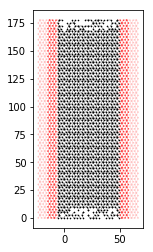

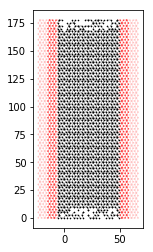

In [18]:
kwant.plotter.plot(system)

In [20]:
result_zero_splitgate = []
size = 0.3
for depth in np.arange(5, 30, 2.5):
    par = SimpleNamespace(t=1, eta=2.5, B=0.0, gamma1=0.4, v_sg=0.0, v_bg=0.2, v_dis=0.0)
    system=make_system_armchair()
    smatrix = kwant.smatrix(system, energy=0.0, args=[par])
    result_zero_splitgate.append(smatrix.transmission(1,0))

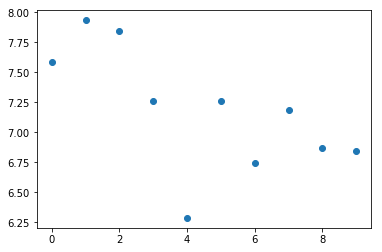

In [21]:
fig, ax = plt.subplots()
ax.plot(result_zero_splitgate, linestyle='None', marker='o')

/home/nefta/git/kwant/kwant/plotter.py:1432: RuntimeWarning: Some sites have nearly coinciding positions, interpolation may be confusing.
  RuntimeWarning)


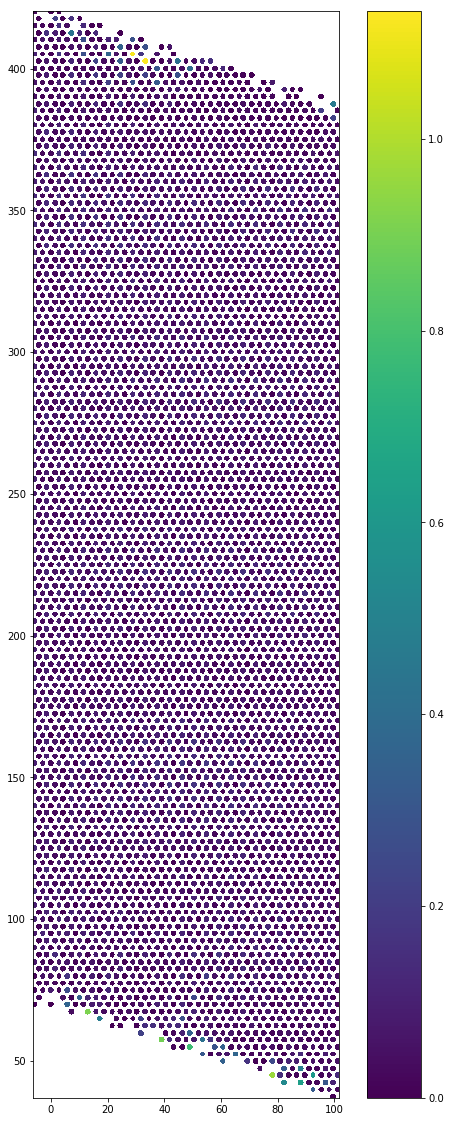

/home/nefta/git/kwant/kwant/plotter.py:1432: RuntimeWarning: Some sites have nearly coinciding positions, interpolation may be confusing.
  RuntimeWarning)


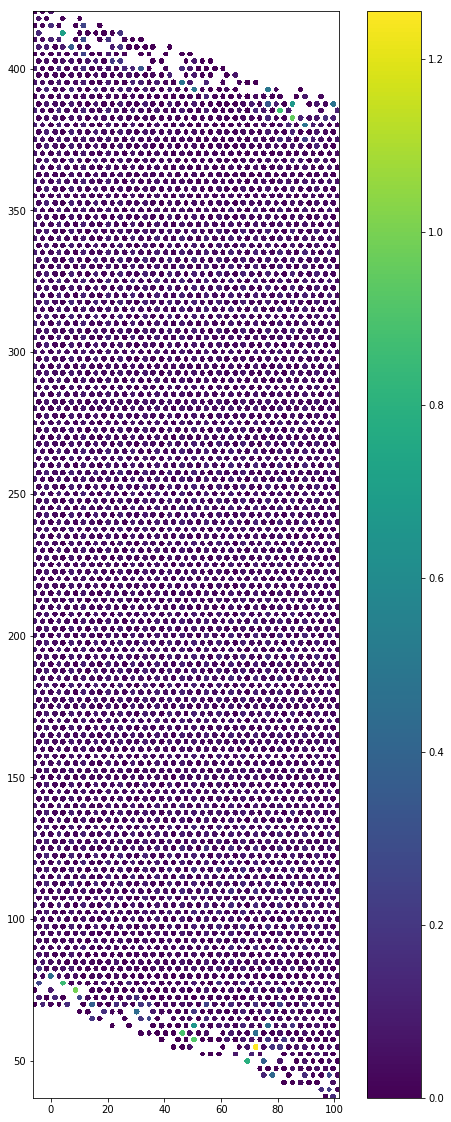

/home/nefta/git/kwant/kwant/plotter.py:1432: RuntimeWarning: Some sites have nearly coinciding positions, interpolation may be confusing.
  RuntimeWarning)


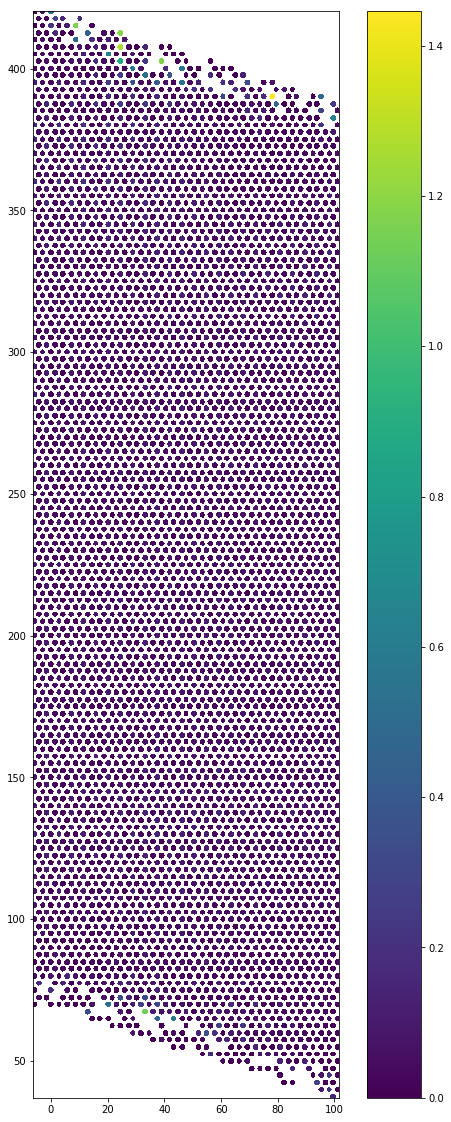

/home/nefta/git/kwant/kwant/plotter.py:1432: RuntimeWarning: Some sites have nearly coinciding positions, interpolation may be confusing.
  RuntimeWarning)


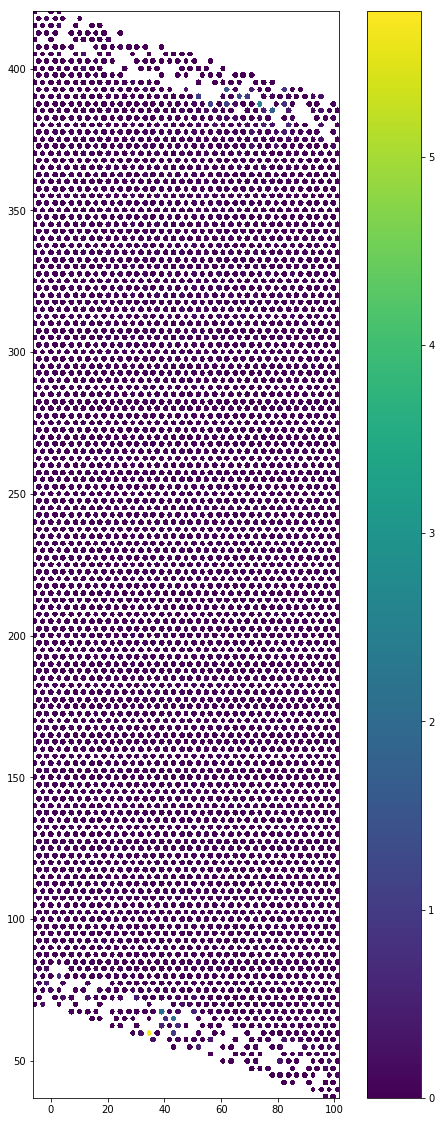

/home/nefta/git/kwant/kwant/plotter.py:1432: RuntimeWarning: Some sites have nearly coinciding positions, interpolation may be confusing.
  RuntimeWarning)


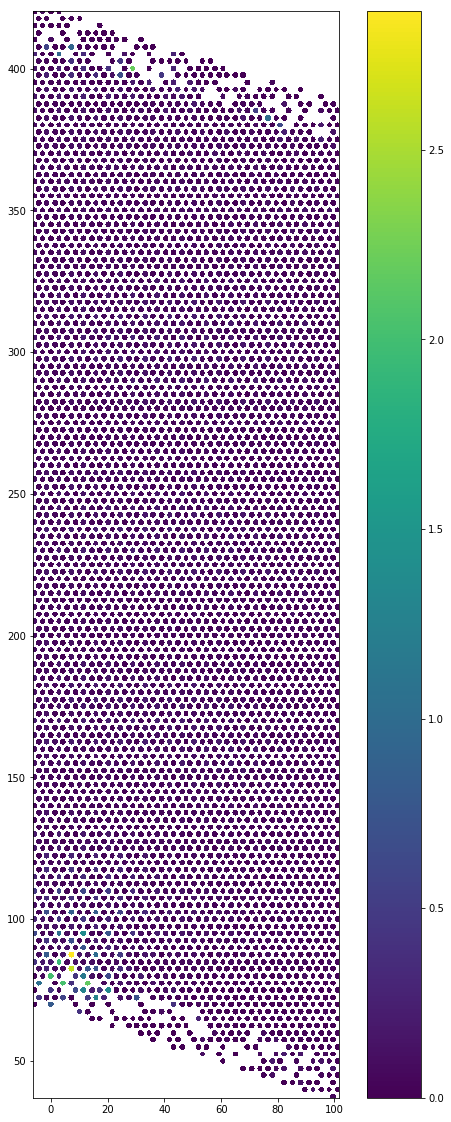

/home/nefta/git/kwant/kwant/plotter.py:1432: RuntimeWarning: Some sites have nearly coinciding positions, interpolation may be confusing.
  RuntimeWarning)


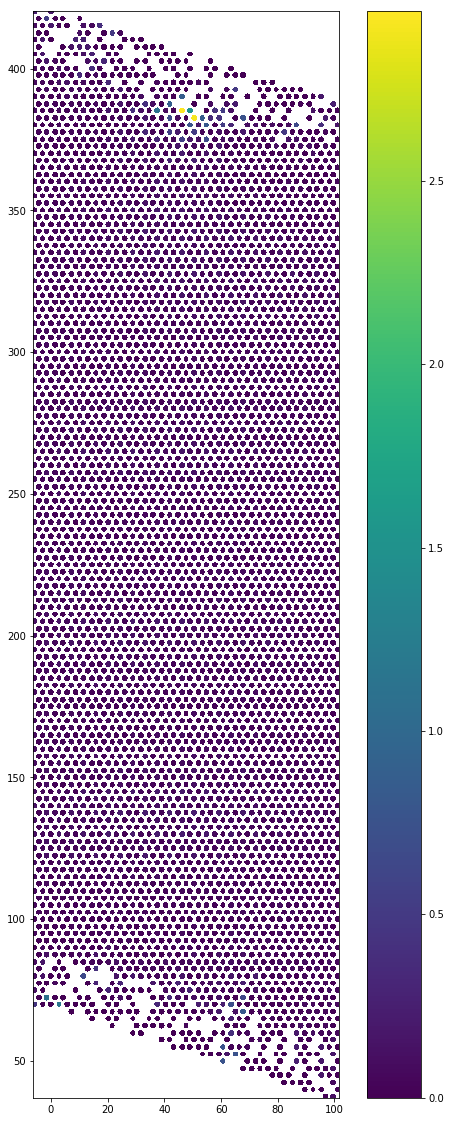

/home/nefta/git/kwant/kwant/plotter.py:1432: RuntimeWarning: Some sites have nearly coinciding positions, interpolation may be confusing.
  RuntimeWarning)


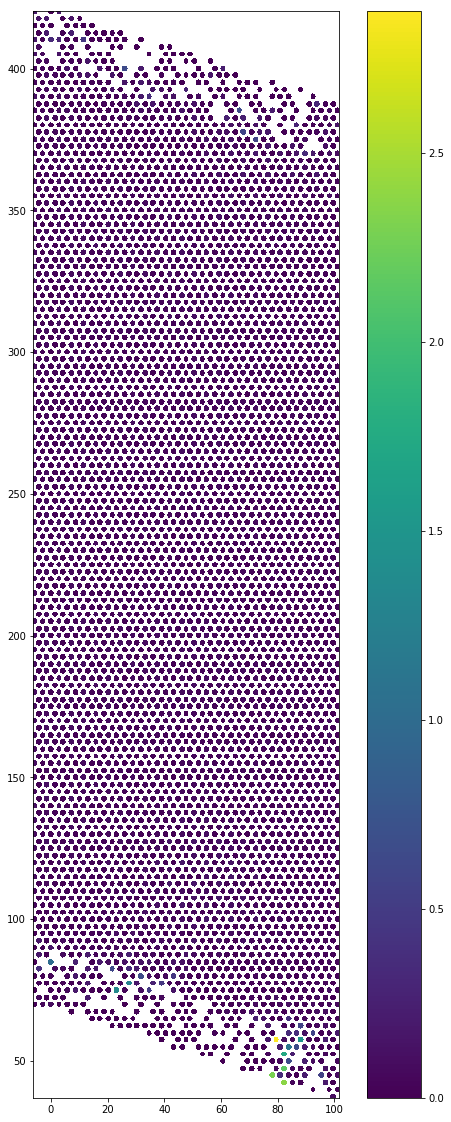

/home/nefta/git/kwant/kwant/plotter.py:1432: RuntimeWarning: Some sites have nearly coinciding positions, interpolation may be confusing.
  RuntimeWarning)


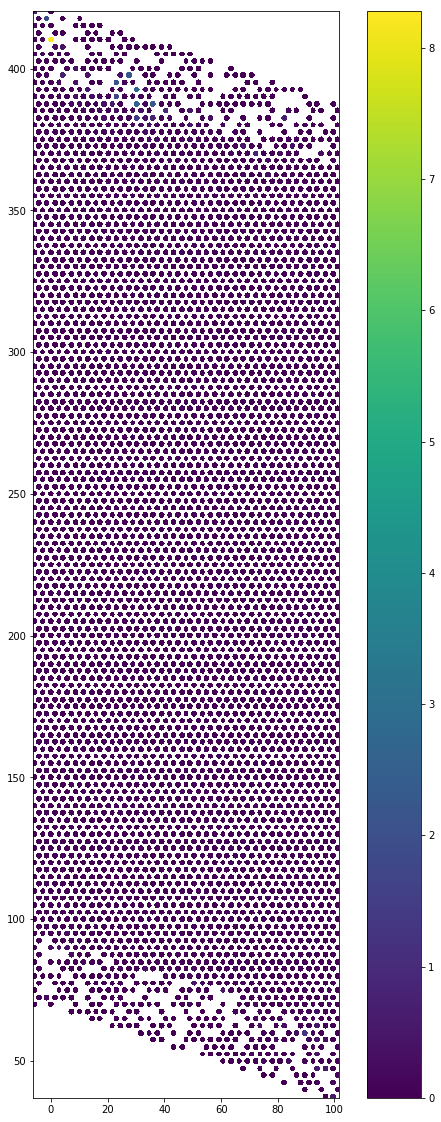

/home/nefta/git/kwant/kwant/plotter.py:1432: RuntimeWarning: Some sites have nearly coinciding positions, interpolation may be confusing.
  RuntimeWarning)


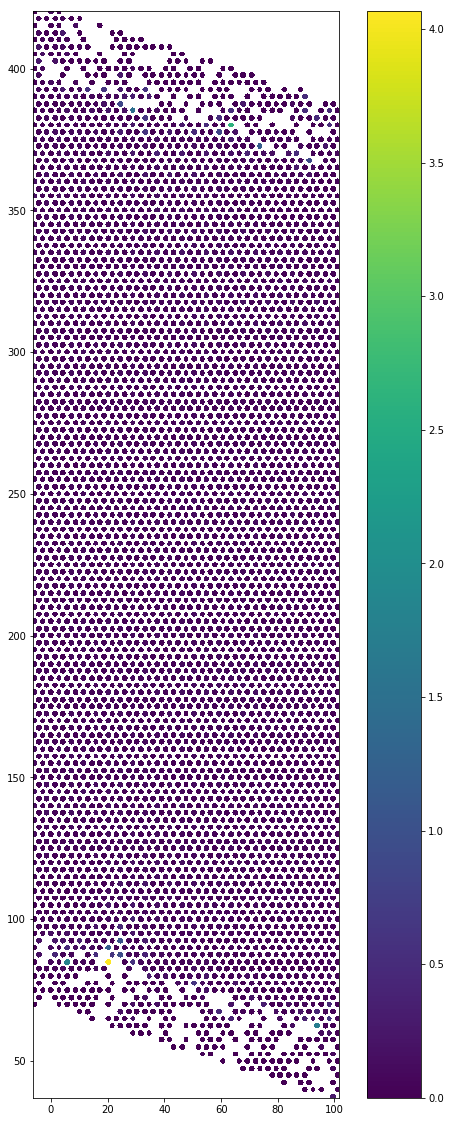

/home/nefta/git/kwant/kwant/plotter.py:1432: RuntimeWarning: Some sites have nearly coinciding positions, interpolation may be confusing.
  RuntimeWarning)


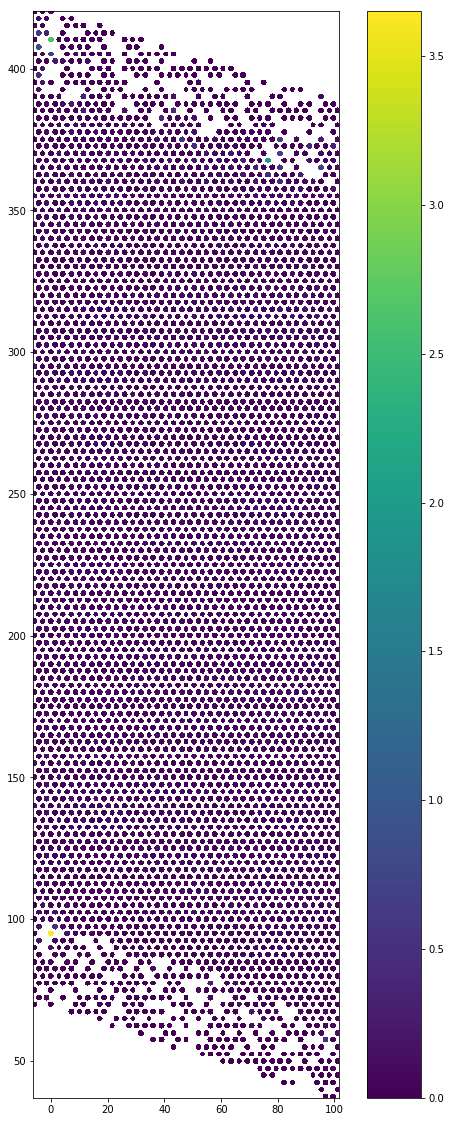

In [24]:
size=0.5
for depth in np.arange(5, 30, 2.5):
    par = SimpleNamespace(t=1, eta=2.5, B=0.0, gamma1=0.4, v_sg=0.0, v_bg=0.2, v_dis=0.0)
    system=make_system_armchair()
    ldos = kwant.ldos(system, args=[par])
    kwant.plotter.map(system, ldos, a=1, fig_size=(10, 20))

In [30]:
result_zigzag = []
size = 0.3
for depth in np.arange(5, 30, 2.5):
    par = SimpleNamespace(t=1, eta=2.5, B=0.0, gamma1=0.4, v_sg=0.0, v_bg=0.2, v_dis=0.0)
    system = make_system_zigzag()
    smatrix = kwant.smatrix(system, energy=0.0, args=[par])
    result_zigzag.append(smatrix.transmission(1,0))

In [32]:
result_zigzag

[8.3610868852340516,
 8.5602513709763688,
 7.9354272697400949,
 7.9885762219497058,
 8.0565534403192185,
 7.4330976034513077,
 7.7270533379706103,
 7.4574654534830698,
 7.1475234085613186,
 7.6241672518338426]

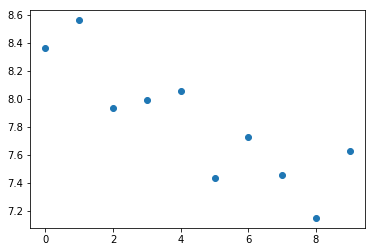

In [33]:
fig, ax = plt.subplots()
ax.plot(result_zigzag, linestyle='None', marker='o')

/home/nefta/git/kwant/kwant/plotter.py:1432: RuntimeWarning: Some sites have nearly coinciding positions, interpolation may be confusing.
  RuntimeWarning)


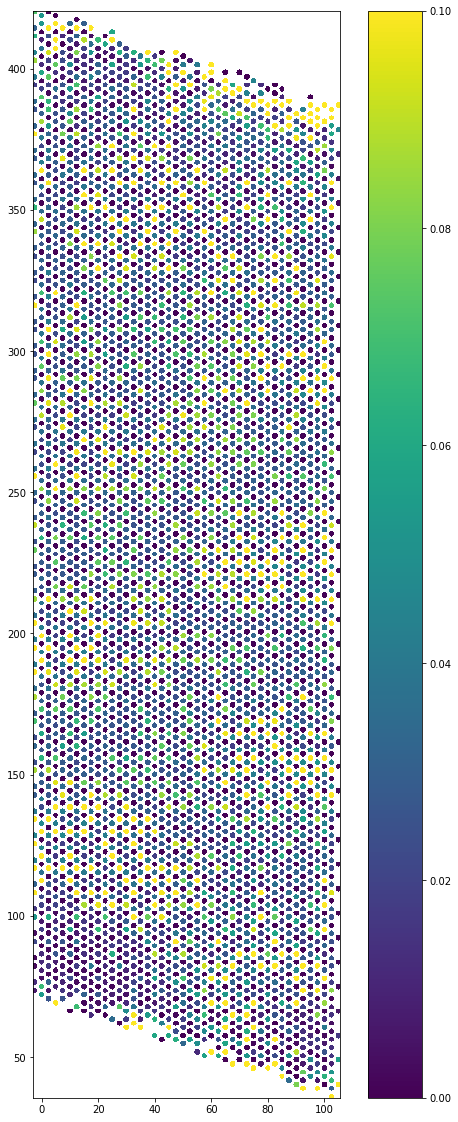

/home/nefta/git/kwant/kwant/plotter.py:1432: RuntimeWarning: Some sites have nearly coinciding positions, interpolation may be confusing.
  RuntimeWarning)


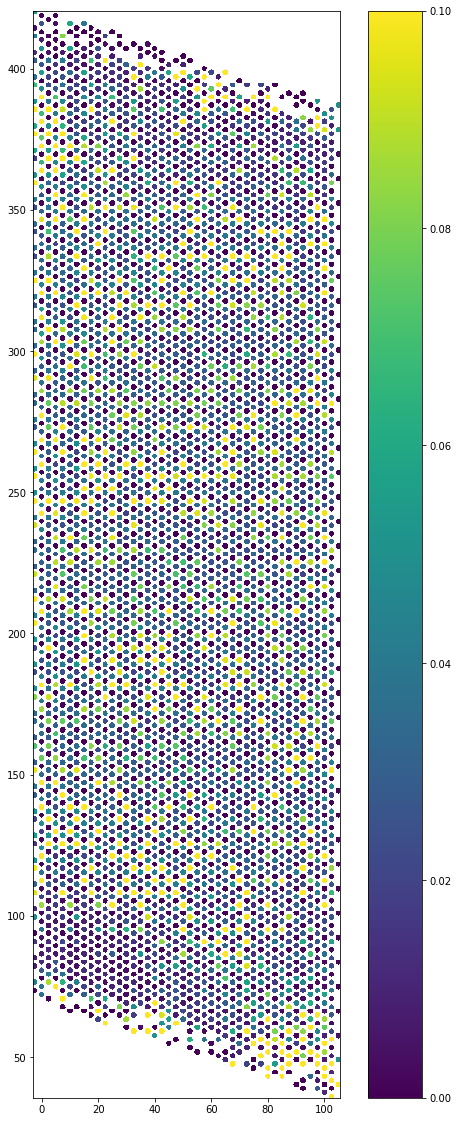

/home/nefta/git/kwant/kwant/plotter.py:1432: RuntimeWarning: Some sites have nearly coinciding positions, interpolation may be confusing.
  RuntimeWarning)


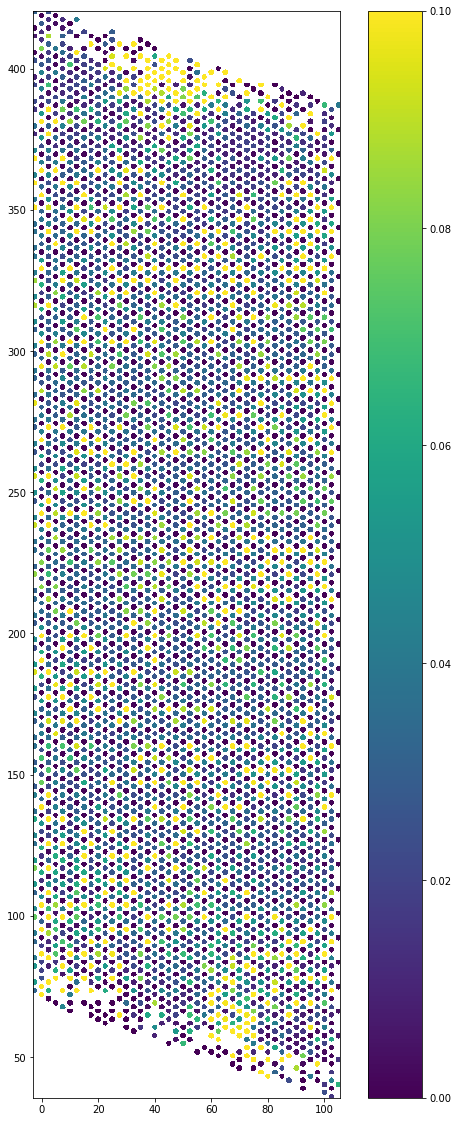

/home/nefta/git/kwant/kwant/plotter.py:1432: RuntimeWarning: Some sites have nearly coinciding positions, interpolation may be confusing.
  RuntimeWarning)


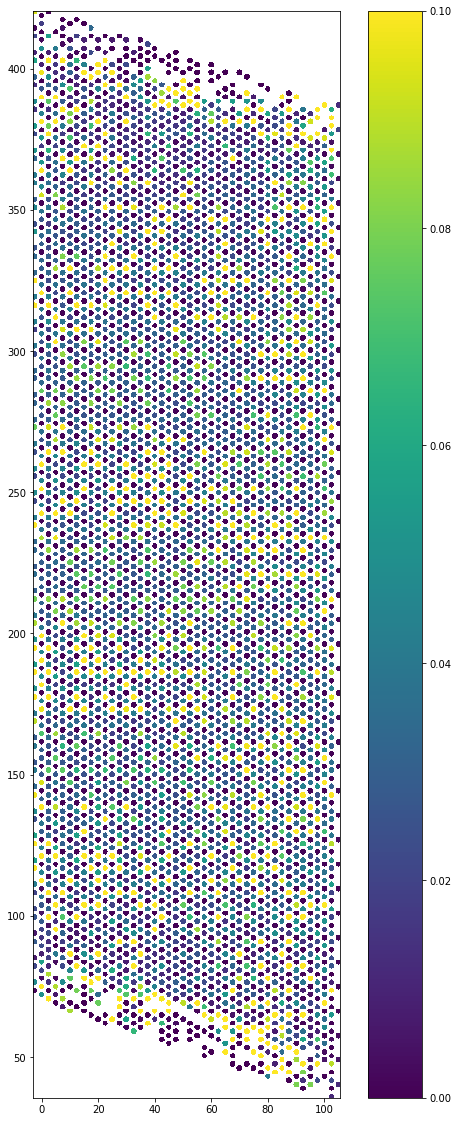

/home/nefta/git/kwant/kwant/plotter.py:1432: RuntimeWarning: Some sites have nearly coinciding positions, interpolation may be confusing.
  RuntimeWarning)


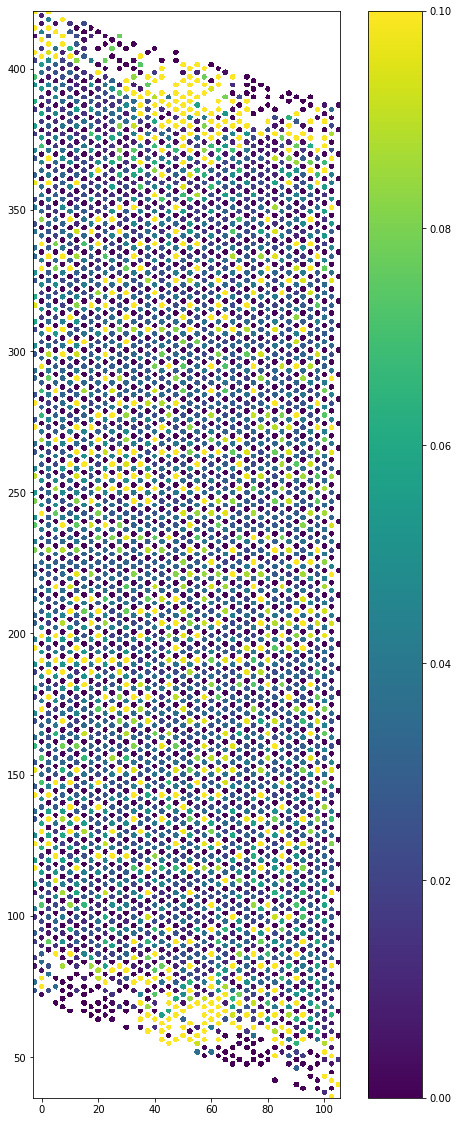

/home/nefta/git/kwant/kwant/plotter.py:1432: RuntimeWarning: Some sites have nearly coinciding positions, interpolation may be confusing.
  RuntimeWarning)


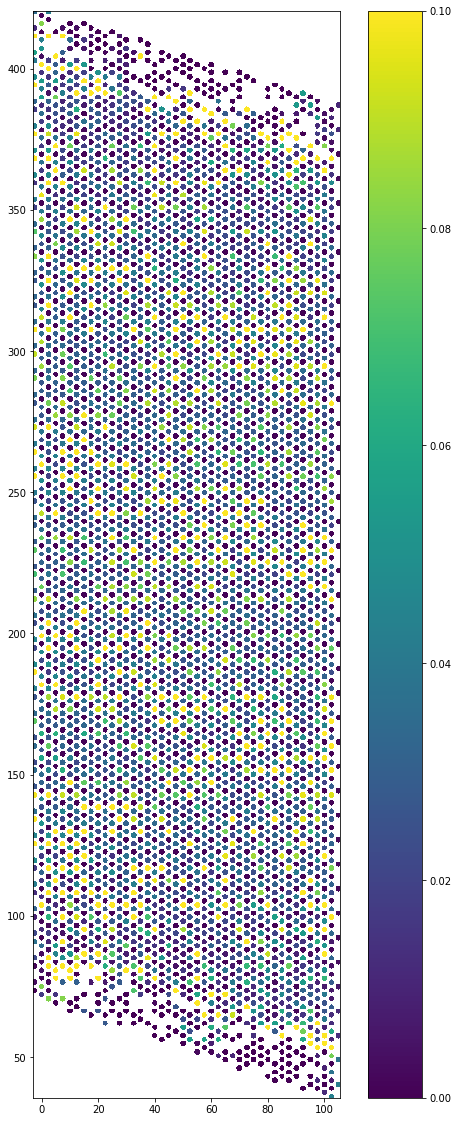

/home/nefta/git/kwant/kwant/plotter.py:1432: RuntimeWarning: Some sites have nearly coinciding positions, interpolation may be confusing.
  RuntimeWarning)


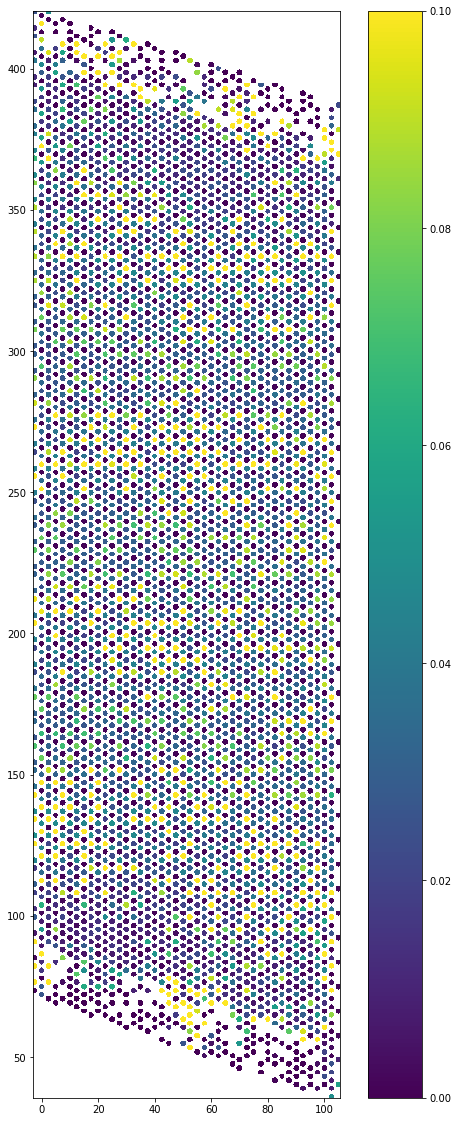

/home/nefta/git/kwant/kwant/plotter.py:1432: RuntimeWarning: Some sites have nearly coinciding positions, interpolation may be confusing.
  RuntimeWarning)


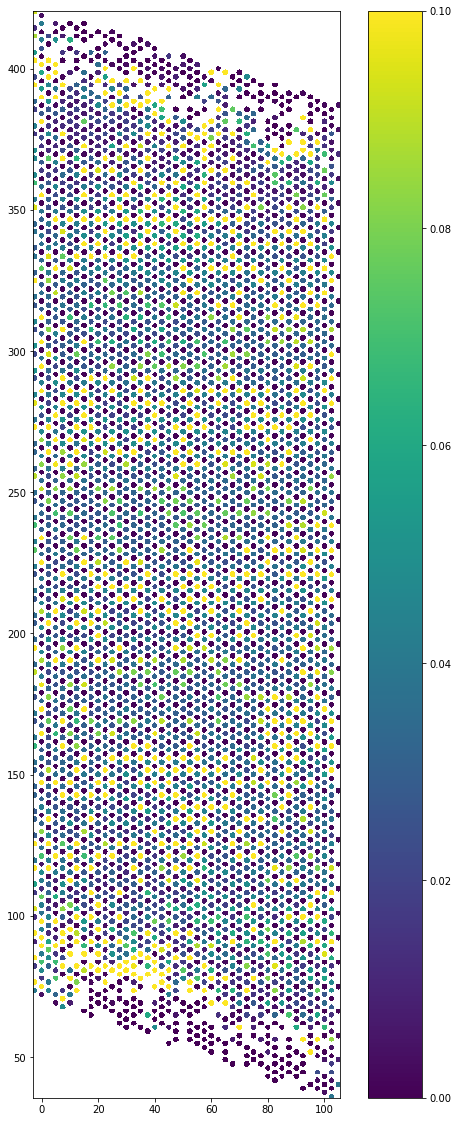

/home/nefta/git/kwant/kwant/plotter.py:1432: RuntimeWarning: Some sites have nearly coinciding positions, interpolation may be confusing.
  RuntimeWarning)


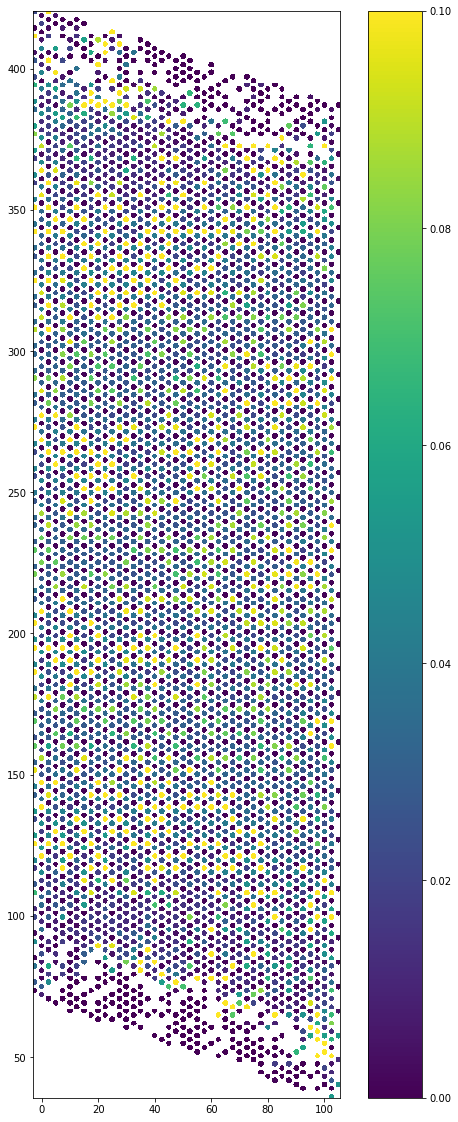

/home/nefta/git/kwant/kwant/plotter.py:1432: RuntimeWarning: Some sites have nearly coinciding positions, interpolation may be confusing.
  RuntimeWarning)


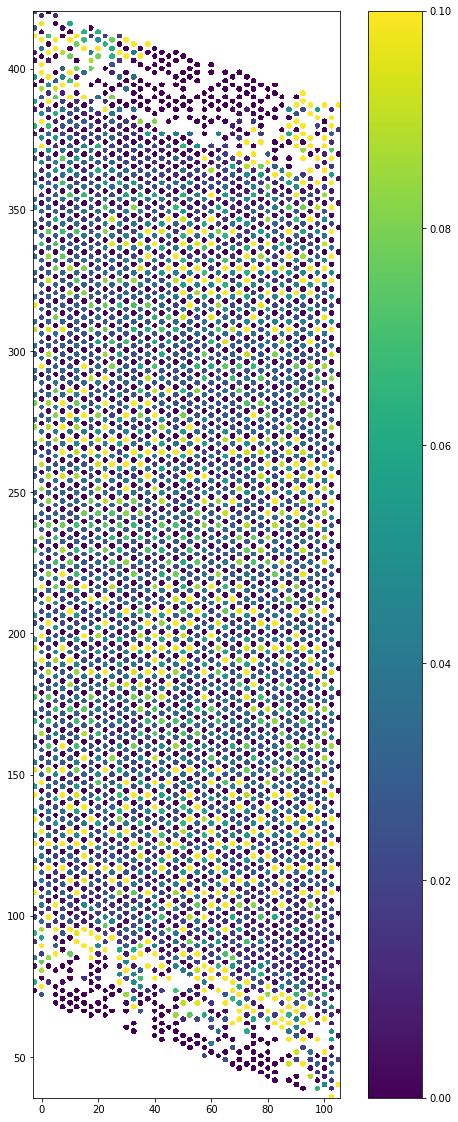

In [35]:
size=0.5
for depth in np.arange(5, 30, 2.5):
    par = SimpleNamespace(t=1, eta=2.5, B=0.0, gamma1=0.4, v_sg=0.0, v_bg=0.2, v_dis=0.0)
    system=make_system_zigzag()
    ldos = kwant.ldos(system, args=[par])
    kwant.plotter.map(system, ldos, a=1,vmax=0.1, fig_size=(10, 20))

/home/nefta/git/kwant/kwant/plotter.py:1432: RuntimeWarning: Some sites have nearly coinciding positions, interpolation may be confusing.
  RuntimeWarning)


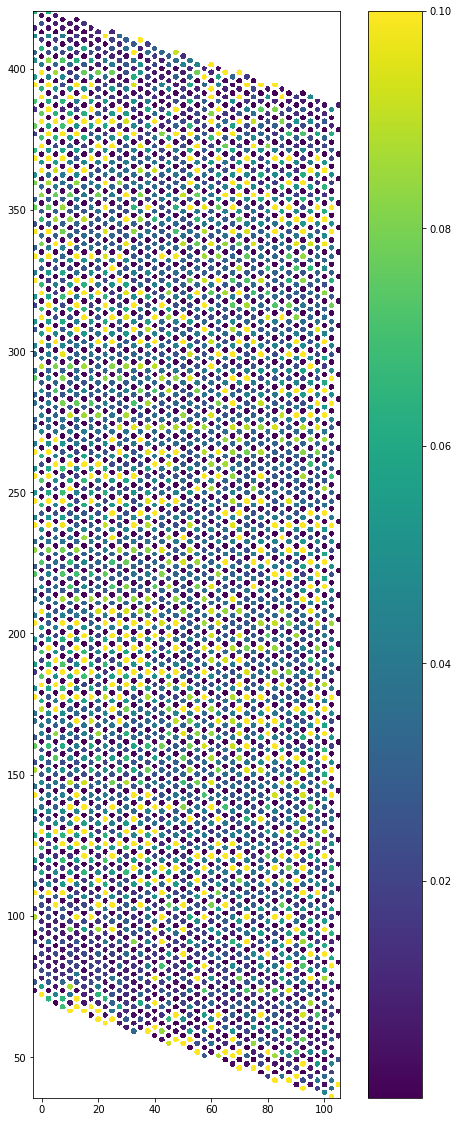

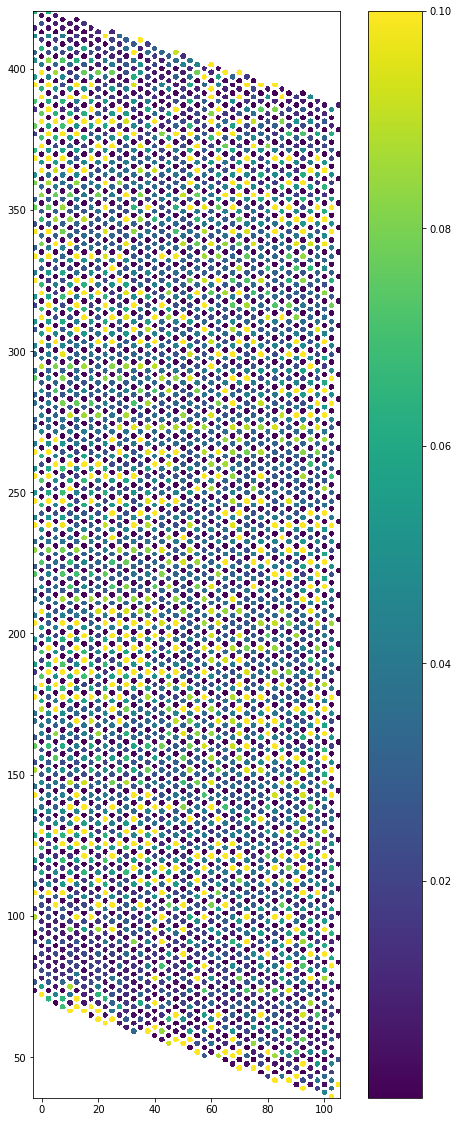

In [40]:
depth = 0.0
par = SimpleNamespace(t=1, eta=2.5, B=0.0, gamma1=0.4, v_sg=0.0, v_bg=0.2, v_dis=0.0)
system=make_system_zigzag()
ldos = kwant.ldos(system, args=[par])
kwant.plotter.map(system, ldos, a=1,vmax=0.1, fig_size=(10, 20))

/home/nefta/git/kwant/kwant/plotter.py:1432: RuntimeWarning: Some sites have nearly coinciding positions, interpolation may be confusing.
  RuntimeWarning)


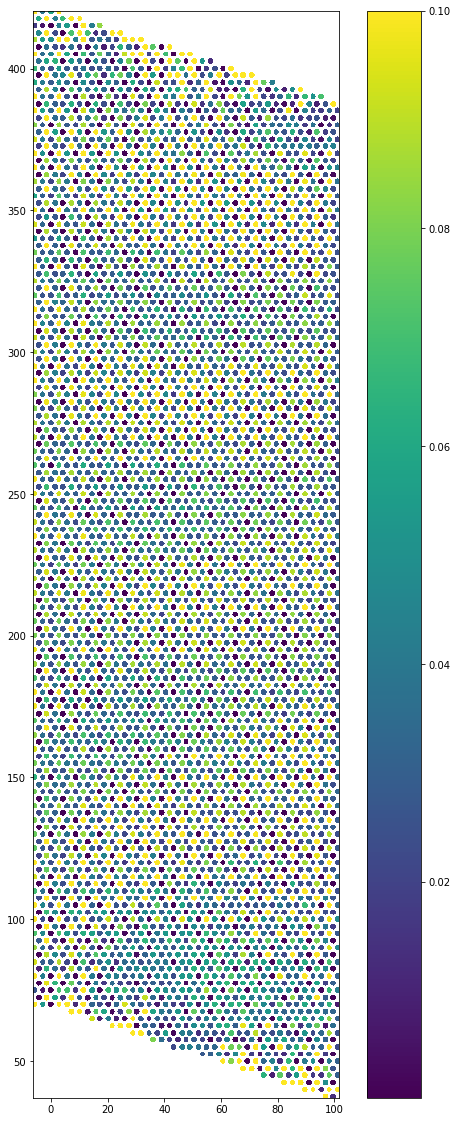

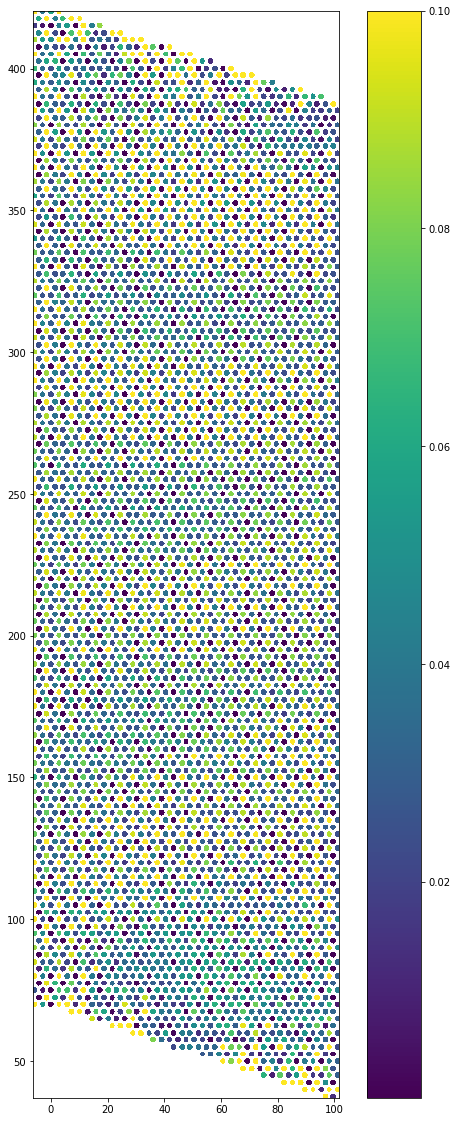

In [43]:
depth = 0.0
par = SimpleNamespace(t=1, eta=2.5, B=0.0, gamma1=0.4, v_sg=0.0, v_bg=0.2, v_dis=0.0)
system=make_system_armchair()
ldos = kwant.ldos(system, args=[par])
kwant.plotter.map(system, ldos, a=1,vmax=0.1, fig_size=(10, 20))